In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import mpld3
from functions import dataToTimeSeries

In [2]:
df = pd.read_csv('./dataframes/data_preprocessed_seconds.csv')
df.head()

,DateTime,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime,alarm_11225,alarm_11231
0,2022-01-01 00:00:00,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
1,2022-01-01 00:00:01,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
2,2022-01-01 00:00:02,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
3,2022-01-01 00:00:03,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
4,2022-01-01 00:00:04,-73.820892,0.126587,-2.549911,NaN,NaN,NaN


In [3]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.fillna(0, inplace=True)
df.set_index('DateTime', inplace=True)
df.head()

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime,alarm_11225,alarm_11231
DateTime,,,,,,
2022-01-01 00:00:00,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:01,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:02,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:03,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:04,-73.820892,0.126587,-2.549911,0.0,0.0,0.0


In [4]:
tags = df.iloc[:,0:3].columns.tolist()
alarms = df.iloc[:,3:].columns.tolist()
agg_dict = {col: 'max' if col in alarms else 'mean' for col in df.columns}

In [5]:
df_minute = df.groupby(pd.Grouper(freq='1T')).agg(agg_dict)

<Axes: xlabel='DateTime'>

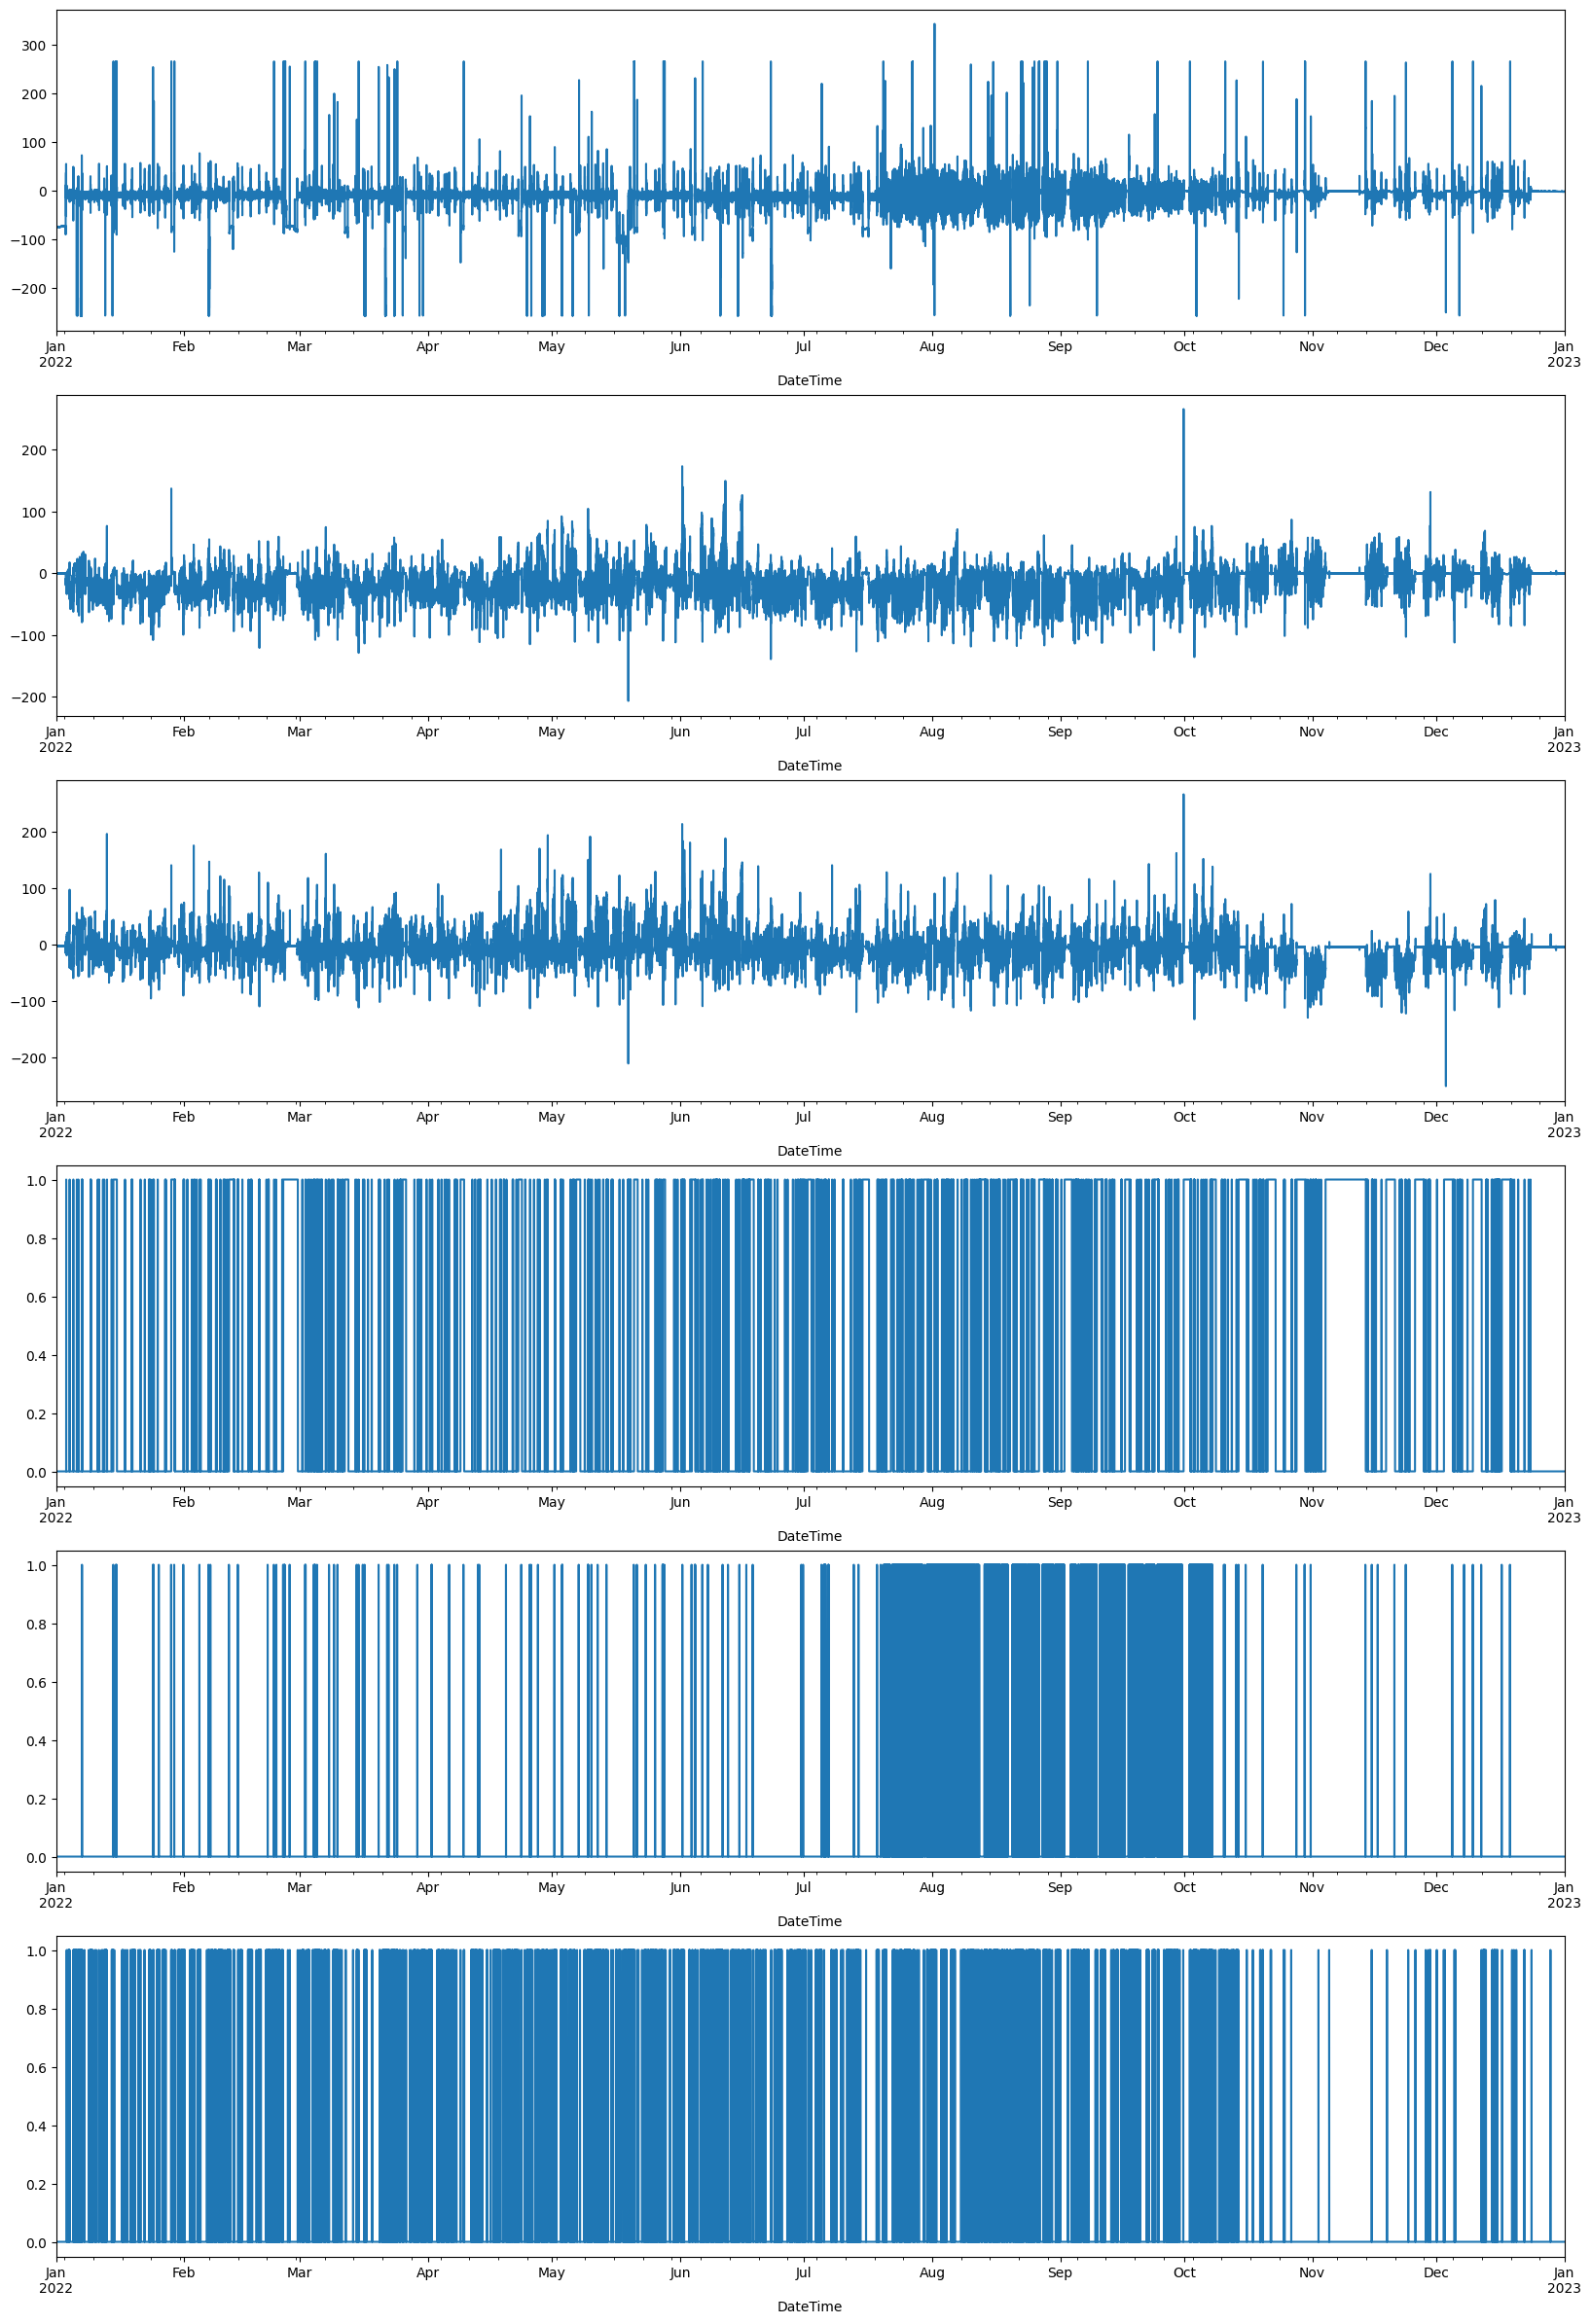

In [6]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(20,30))
df_minute['GLA3_CO_258_024'].plot(ax =ax1)
df_minute['GLA3_CO_258_028'].plot(ax=ax2)
df_minute['GLA3_CO_258_032'].plot(ax=ax3)
df_minute['downtime'].plot(ax =ax4)
df_minute['alarm_11225'].plot(ax=ax5)
df_minute['alarm_11231'].plot(ax=ax6)


In [7]:
numerical_cols = ['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032']
categorical_cols = ['alarm_11225', 'downtime', 'alarm_11231']

In [8]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

In [9]:
data = df.copy()

In [10]:
numerical_cols = ['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032']
categorical_cols = ['alarm_11225', 'downtime', 'alarm_11231']

In [11]:
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [12]:
X = data[['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032']].values
y = data['downtime'].values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [14]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [17]:
print(f'X shape is {X_train.shape[0]} and after resampling {X_resampled.shape[0]}')

X shape is 22075200 and after resampling 8992156


In [18]:
def trainingModel(model):
    model = model
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

In [19]:
model_generator = (model for model in [LogisticRegression(class_weight='balanced'), DecisionTreeClassifier(class_weight='balanced')])

In [20]:
trainingModel(DecisionTreeClassifier())

Accuracy: 0.978344434049506


In [21]:
model = DecisionTreeClassifier()
model.fit(X_resampled, y_resampled)
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['downtime','no-downtime']))

              precision    recall  f1-score   support

    downtime       1.00      0.98      0.99   7532362
 no-downtime       0.91      0.99      0.95   1928439

    accuracy                           0.98   9460801
   macro avg       0.95      0.98      0.97   9460801
weighted avg       0.98      0.98      0.98   9460801



In [31]:
results = pd.DataFrame(y_test, y_pred)
results = results.reset_index()
results = results.rename(columns={'index':'y_test', 0:'y_pred'})
results.head()

,y_test,y_pred
0,1,1
1,1,1
2,0,0
3,1,1
4,0,0


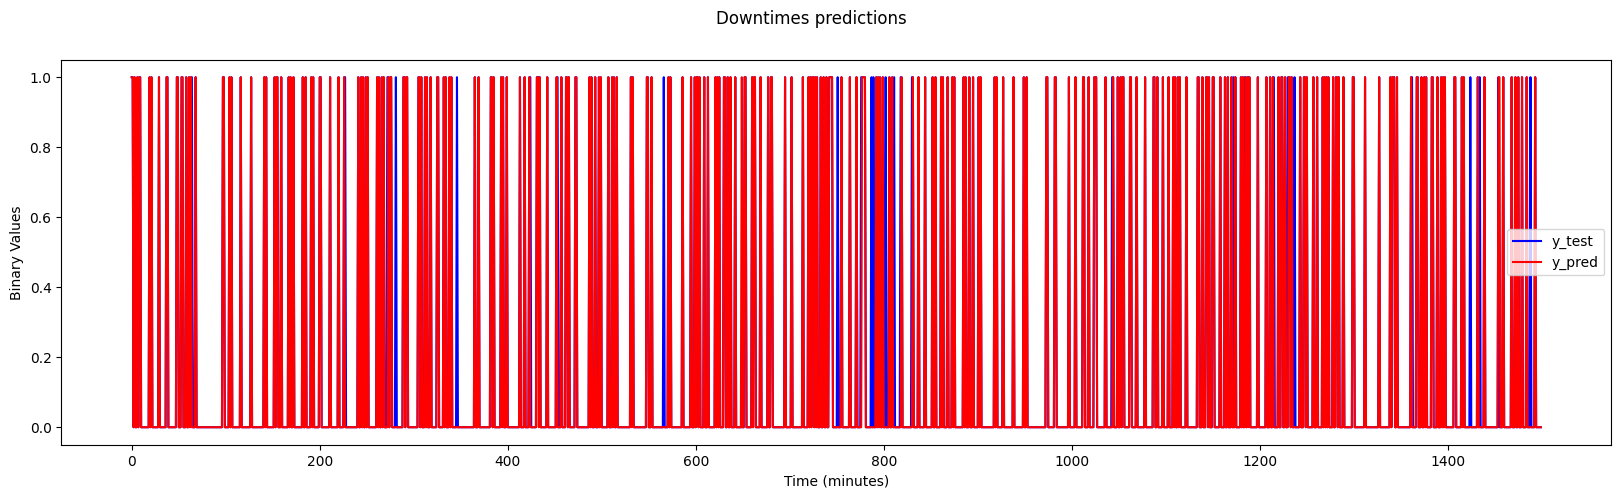

In [43]:
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))
fig, ax = plt.subplots(figsize=(20,5))

# plot the first column on the first subplot
results['y_test'][:1500].plot(ax=ax, color='blue', label='y_test')
results['y_pred'][:1500].plot(ax=ax, color='red', label='y_pred')
ax.set_ylabel('Binary Values')

# add a legend and axis labels to the whole figure
fig.suptitle('Downtimes predictions')
plt.xlabel('Time (minutes)')
plt.legend()

# show the plot
plt.show()